# Multiclass Random Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from scipy.interpolate import spline, BSpline
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, normalize
from collections import Counter
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

In [161]:
def plot_dict_compare(score, X_axis, title, filename, color):

    xnew = np.linspace(X_axis[0], X_axis[-1], 100)
    score_smooth = spline(X_axis, score, xnew)
    plt.figure()
    plt.figure(figsize=(20,10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(title, fontsize=30)
    plt.xlabel('N Features', fontsize=28)
    plt.ylabel('Score', fontsize=28)
    plt.plot(xnew, score_smooth, linewidth=3, color=color)
    
    best_index = np.argsort(score)[::-1][:3]
    best_scores = sorted(score)[::-1][:3]
    
    for i in range(1,38):
        plt.axvline(x=i, linestyle='--', color='grey', linewidth=0.5)

    for i,s in zip(best_index, best_scores):
        # Annotate the best score for that scorer
        plt.annotate("%0.4f (n=%d)" % (s, X_axis[i]),
                    (X_axis[i]-4, s - 0.02), fontsize=24)
    
    plt.savefig('data/full/' + filename + '.png')
    plt.show()

In [162]:
import matplotlib.patches as mpatches
def plot_features_trend(score, X_axis, title, filename, color):

    xnew = np.linspace(X_axis[0], X_axis[-1], 100)
    score_smooth = spline(X_axis, score, xnew)
    plt.figure()
    plt.figure(figsize=(20,10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(title, fontsize=30)
    plt.xlabel('N Features', fontsize=28)
    plt.ylabel('Score', fontsize=28)
    plt.plot(xnew, score_smooth, linewidth=3, color=color)
    
    best_index = np.argsort(score)[::-1][:3]
    best_scores = sorted(score)[::-1][:3]
    
    for i in range(1,38):
        plt.axvline(x=i, linestyle='--', color='grey', linewidth=0.5)

    
    red_patch = mpatches.Patch(color=color,label="1st - %0.4f (%d features)" % (best_scores[0], X_axis[best_index[0]]))
    green_patch = mpatches.Patch(color=color,label="2nd - %0.4f (%d features)" % (best_scores[1], X_axis[best_index[1]]))
    blue_patch = mpatches.Patch(color=color,label="3rd - %0.4f (%d  features)" % (best_scores[2], X_axis[best_index[2]]))

    plt.legend(handles=[red_patch, green_patch, blue_patch],loc="best", fontsize=24)
    
    plt.savefig('data/full/' + filename + '.png')
    plt.show()

In [163]:
def features_trend(forest):
    
    forest.fit(X,y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:len(importances)]
    
    precision = []
    recall = []
    f1 = []
    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    for i in range(1,len(indices)+1):
        index = indices[0:i]
        features = X.columns[index]
        cv = cross_validate(forest, X[features], y, cv=10, scoring=scoring, n_jobs=-1)
        
        precision.append(cv['test_precision_macro'].mean())
        recall.append(cv['test_recall_macro'].mean())
        f1.append(cv['test_f1_macro'].mean())
        print(str(i) + ' features tested')
    
    X_axis = np.arange(1, len(importances)+1)
    
    return precision, recall, f1, X_axis
    

In [24]:
def plot_importance(forest, feature_group, X, limit):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1][:len(importances)]

    # Print the feature ranking
    print("Feature ranking:")

    for f,i in zip(range(12),indices):
        print("%d. %s (%f)" % (f + 1, X.columns[i], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.figure(figsize=(20,10))

    plt.title("Feature importances", fontsize=30)
    plt.bar(range(12), importances[indices[:12]],
           color="r", yerr=std[indices[:12]], align="center")
    labels = []
    for l in X.columns[indices[:12]]:
        labels.append(str(l[0:limit]) + '...')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=28)
    plt.xticks(range(len(importances)), labels)
    plt.xlim([-1, 12])
    plt.savefig('data/full/' + feature_group + '_importances.png')
    plt.show()

In [165]:
def evaluate(feature_group, X, y, limit, n_estimators = 250, criterion = 'entropy'):
    forest = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth=None, n_jobs=-1)
    forest.fit(X,y)
    scoring = ['f1_macro', 'precision_macro', 'recall_macro'] 
    scores = []
    cv = cross_validate(forest, X, y, cv=10, scoring=scoring)
    scores.append(cv['test_precision_macro'].mean())
    scores.append(cv['test_recall_macro'].mean())
    scores.append(cv['test_f1_macro'].mean())
    plot_importance(forest, feature_group, X, limit)
    return scores

In [166]:
def cv(model):
    scoring = ['f1_macro', 'precision_macro', 'recall_macro'] 
    scores = []
    cv = cross_validate(model, X, y, cv=10, scoring=scoring)
    scores.append(cv['test_precision_macro'].mean())
    scores.append(cv['test_recall_macro'].mean())
    scores.append(cv['test_f1_macro'].mean())
    return scores

In [32]:
def grid_eval(X, y, params):
    
    grid = GridSearchCV(RandomForestClassifier(), params, cv=10, scoring='f1_macro')
    grid.fit(X, y)
    
    return pd.DataFrame(grid.cv_results_)

In [234]:
def grid_search(X, y, params):
    
    results = []
    for x, f in zip(X,[50, 100, 150, 200]):
        grid = GridSearchCV(RandomForestClassifier(), params, cv=10, scoring='f1_macro')
        grid.fit(x, y)
        d1 = {'features': f}
        d2 = dict(list(grid.cv_results_.items()) + list(d1.items()))
        results.append(d2)
        print(str(f) + ' done')

    return results

In [33]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, title, filename):
    # Get Test Scores Mean and std for each grid search
    
    cv_results.reset_index(drop=True, inplace=True)
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))
    
    xnew = np.linspace(grid_param_1[0], grid_param_1[-1], 200)

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize=(16,12))
    

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    #color = ['blue', 'g', 'r', 'y', 'grey']
    #i = 0
    for idx, val in enumerate(grid_param_2):
        #c = color[i]
        #i += 1
        score_smooth = spline(grid_param_1, scores_mean[idx,:], xnew)
        avg = [scores_mean[idx,:].mean()] * len(xnew)
        ax.plot(grid_param_1, scores_mean[idx,:], '-', label= name_param_2 + ': ' + str(val), linewidth=4,)
        #ax.plot(xnew, avg, '--', color=c, label= name_param_2 + ': ' + str(val) + ' words - avg', linewidth=3,)
    
    
    
    best_index = cv_results['mean_test_score'].values.argmax()
    best_param = cv_results.loc[best_index]['param_n_estimators']
    best_score = cv_results['mean_test_score'].max()
    min_score = cv_results['mean_test_score'].min()
    plt.axvline(x=best_param, linestyle=':', color='grey', linewidth=2)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.plot([best_param,], [best_score],
           linestyle=':', color='black', markeredgewidth=3,markersize=26, ms=8)
    
    plt.annotate("%0.4f (n_estimatores = %d)" % (best_score, best_param),
                    (best_param-50, best_score+0.00001), fontsize=24)
    

    ax.tick_params(labelsize=20)
    ax.set_title(title, fontsize=30)
    ax.set_xlabel(name_param_1, fontsize=28)
    ax.set_ylabel('F1 Macro Score', fontsize=28)
    ax.legend(loc="lower right", fontsize=22)
    ax.grid('on')
    fig.savefig('data/full/'+ filename +'.png')

In [3]:
full = pd.read_csv('data/full/1000_new_train.csv')

In [4]:
full = full.loc[full['target'] != 4]

In [5]:
len(full)

21445

In [7]:
X = full.drop(columns=["user_id", "target"])
y = full['target']

### User features

In [174]:
# only our user features
X_user = X[['default_profile', 'favourites_count', 'followers_count', 'friends_count', 'listed_count','profile_use_background_image',
       'statuses_count', 'url', 'description_len',
       'name_len', 'screen_name_len', 'age']]

Feature ranking:
1. favourites_count (0.343564)
2. statuses_count (0.161290)
3. followers_count (0.147941)
4. friends_count (0.074809)
5. default_profile (0.061792)
6. age (0.056794)
7. url (0.047246)
8. listed_count (0.044101)
9. description_len (0.039879)
10. name_len (0.012001)
11. screen_name_len (0.008582)
12. profile_use_background_image (0.002001)


<Figure size 432x288 with 0 Axes>

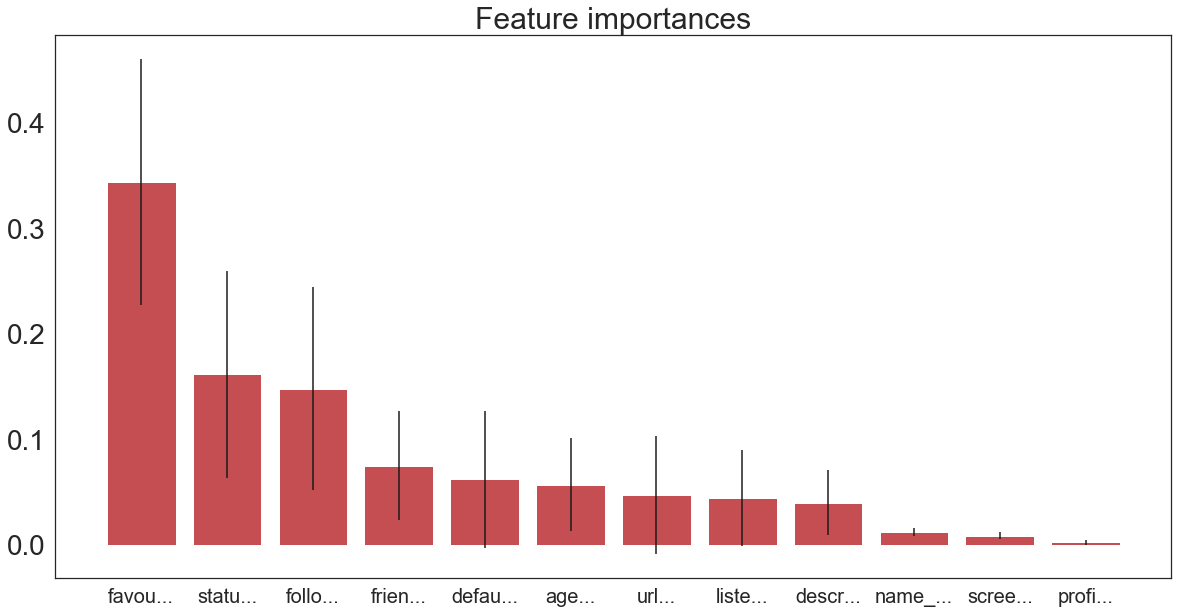

Precision:
0.9327797661811574
Recall:
0.9284037525433704
F1:
0.9233555182740352


In [175]:
user_score = evaluate('user_features', X_user, y, 5)
print('Precision:')
print(user_score[0])
print('Recall:')
print(user_score[1])
print('F1:')
print(user_score[2])

### Descriptive features

In [176]:
# only our descriptive features
X_desc = X[['avg_fav', 'avg_hash', 'avg_len', 'avg_ret',
       'freq', 'max_fav', 'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_hash',
       'min_len', 'min_ret', 'quote_perc',
       'ret_perc', 'url_perc']]

Feature ranking:
1. freq (0.165856)
2. avg_len (0.156603)
3. ret_perc (0.107071)
4. media_perc (0.104336)
5. max_len (0.087121)
6. min_len (0.086561)
7. quote_perc (0.069640)
8. avg_ret (0.062425)
9. max_ret (0.050255)
10. url_perc (0.029297)
11. avg_hash (0.025478)
12. avg_fav (0.018558)
13. max_hash (0.011790)
14. max_fav (0.010583)
15. min_hash (0.009096)
16. min_ret (0.005331)


<Figure size 432x288 with 0 Axes>

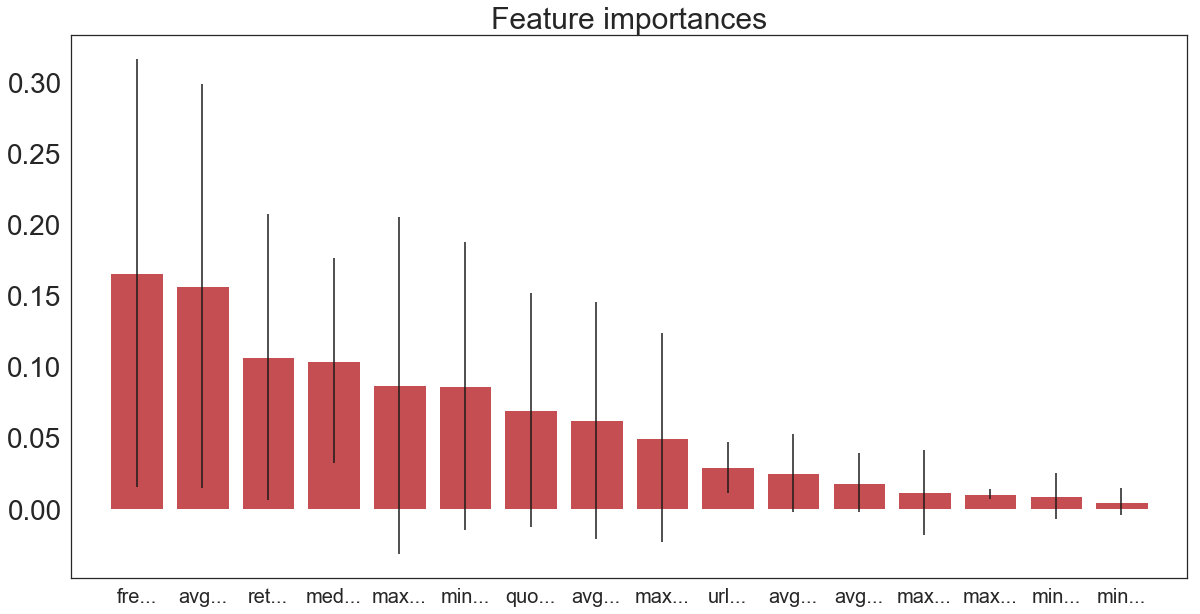

Precision:
0.8617712017264078
Recall:
0.8375014324476435
F1:
0.8293281468347912


In [177]:
desc_score = evaluate('desc_features', X_desc, y, 3)
print('Precision:')
print(desc_score[0])
print('Recall:')
print(desc_score[1])
print('F1:')
print(desc_score[2])

### Intrinsic features

In [178]:
# only our intrinsic features
X_intr = X[['tweet_intradistance','url_entropy']]

Feature ranking:
1. tweet_intradistance (0.733502)
2. url_entropy (0.266498)


<Figure size 432x288 with 0 Axes>

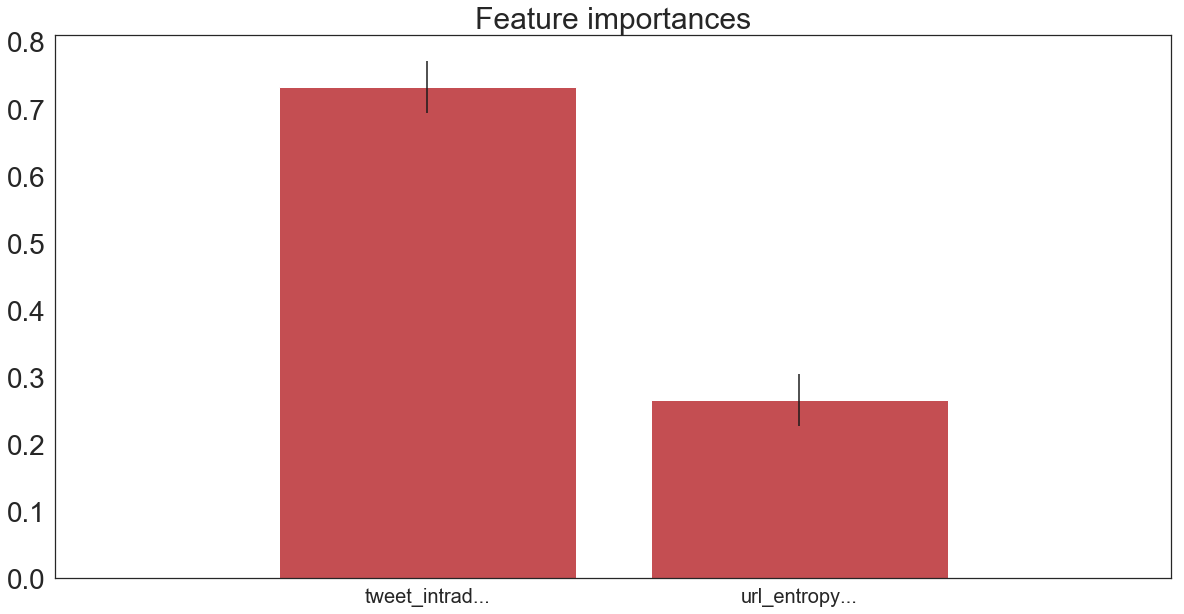

Precision:
0.732652710689824
Recall:
0.7240443986970951
F1:
0.7080520972977746


In [179]:
intr_score = evaluate('intrinisc_features', X_intr, y, 12)
print('Precision:')
print(intr_score[0])
print('Recall:')
print(intr_score[1])
print('F1:')
print(intr_score[2])

### Extrinsic features

In [180]:
# only our extrinsic features
X_extr = X[['NSFW_words_score', 'news_spreaders_words_score', 'spam_bots_words_score', 'fake_followers_words_score']]

Feature ranking:
1. NSFW_words_score (0.330426)
2. spam_bots_words_score (0.329244)
3. news_spreaders_words_score (0.267688)
4. fake_followers_words_score (0.072642)


<Figure size 432x288 with 0 Axes>

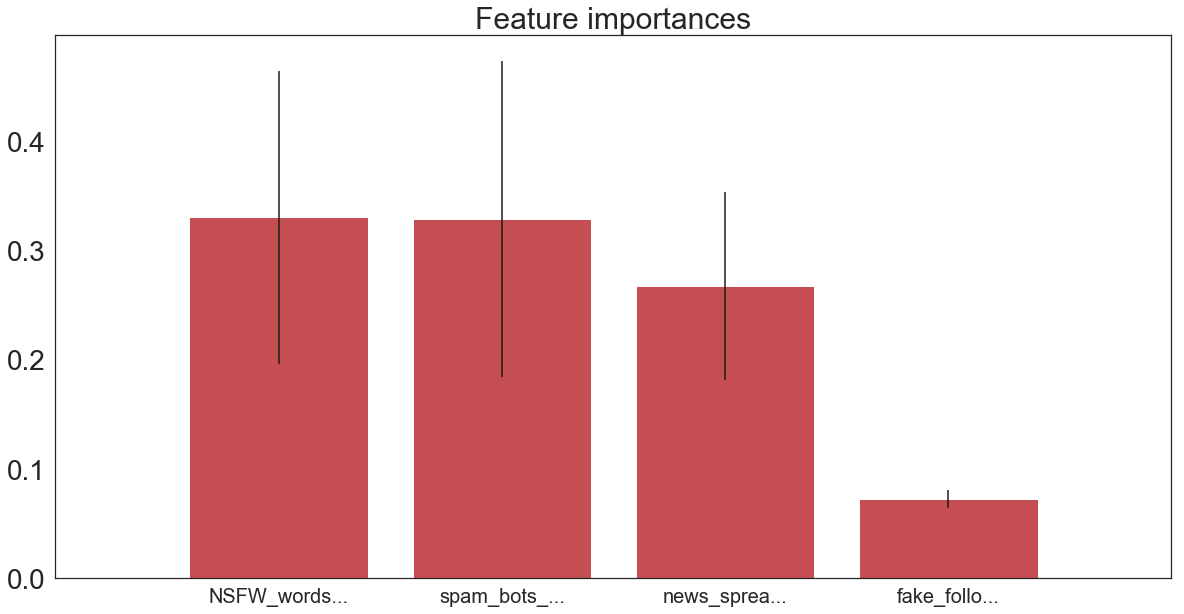

Precision:
0.8359865954926644
Recall:
0.8094597281984587
F1:
0.799501971337061


In [181]:
extr_score = evaluate('extrinsic_features', X_extr, y, 10)
print('Precision:')
print(extr_score[0])
print('Recall:')
print(extr_score[1])
print('F1:')
print(extr_score[2])

### NSFW features

In [182]:
# only our NSFW features
X_imgs = X[['nsfw_avg', 'nsfw_profile']]

Feature ranking:
1. nsfw_profile (0.823657)
2. nsfw_avg (0.176343)


<Figure size 432x288 with 0 Axes>

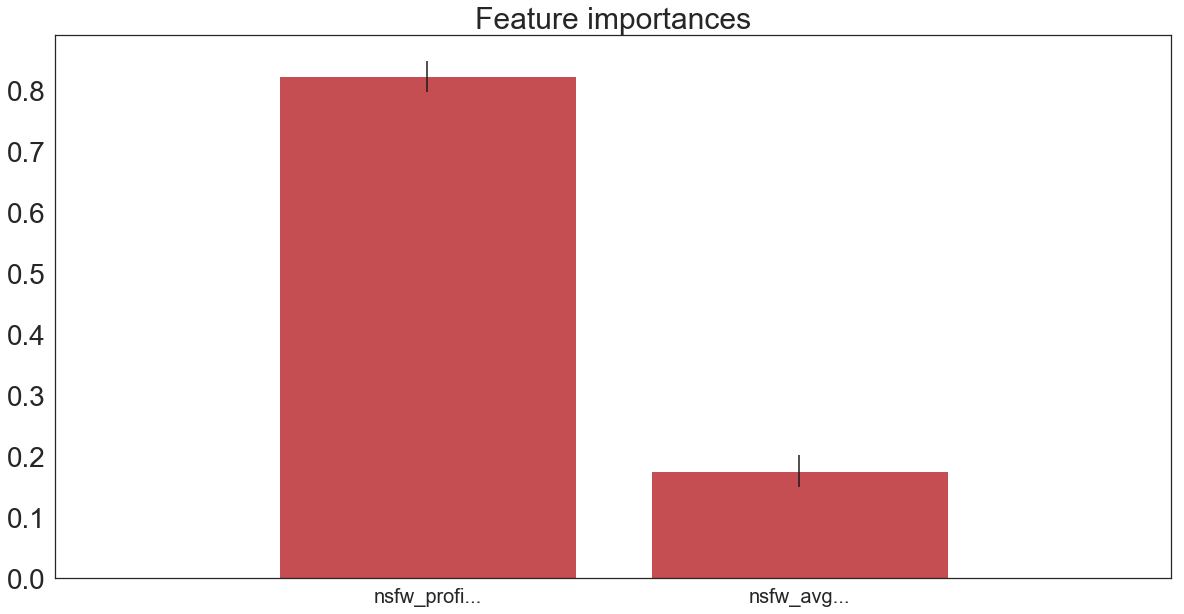

Precision:
0.640927746502619
Recall:
0.6357740499590137
F1:
0.6322357781989656


In [183]:
imgs_score = evaluate('imgs_features', X_imgs, y, 10)
print('Precision:')
print(imgs_score[0])
print('Recall:')
print(imgs_score[1])
print('F1:')
print(imgs_score[2])

### All features

Feature ranking:
1. favourites_count (0.194194)
2. nsfw_profile (0.070284)
3. statuses_count (0.060114)
4. news_spreaders_words_score (0.057899)
5. freq (0.056990)
6. tweet_intradistance (0.055479)
7. avg_len (0.051691)
8. followers_count (0.048191)
9. max_len (0.042249)
10. min_len (0.035353)
11. spam_bots_words_score (0.032846)
12. NSFW_words_score (0.032786)
13. ret_perc (0.031349)
14. media_perc (0.029192)
15. friends_count (0.027051)
16. avg_ret (0.021247)
17. age (0.021179)
18. quote_perc (0.020271)
19. max_ret (0.019553)
20. nsfw_avg (0.015848)
21. default_profile (0.011424)
22. description_len (0.009883)
23. listed_count (0.009323)
24. fake_followers_words_score (0.006703)
25. url (0.006046)
26. url_perc (0.005982)
27. avg_hash (0.005640)
28. url_entropy (0.004938)
29. max_hash (0.002866)
30. min_hash (0.002724)
31. avg_fav (0.002483)
32. max_fav (0.002339)
33. name_len (0.002265)
34. screen_name_len (0.002089)
35. min_ret (0.001013)
36. profile_use_background_image (0.000369)


<Figure size 432x288 with 0 Axes>

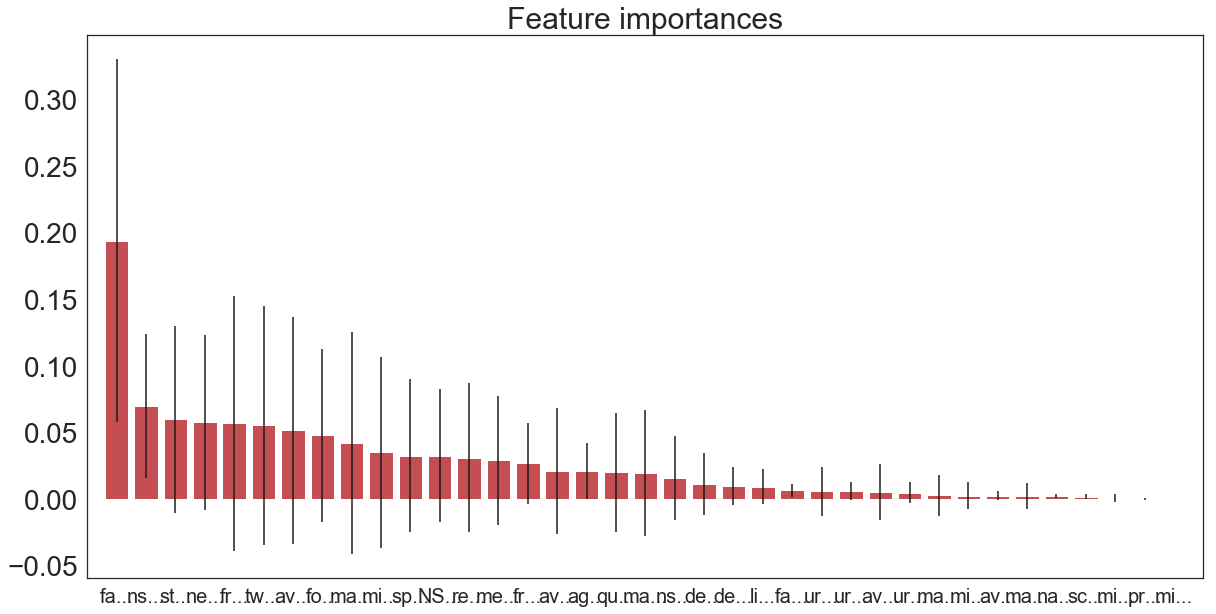

Precision:
0.9781944116334271
Recall:
0.9763833416949508
F1:
0.9768139142113638


In [184]:
all_score = evaluate('all_features', X, y, 2)
print('Precision:')
print(all_score[0])
print('Recall:')
print(all_score[1])
print('F1:')
print(all_score[2])

## Top 12 features plot

In [11]:
forest = RandomForestClassifier(n_estimators = 250, criterion = 'entropy', max_depth=None, n_jobs=-1)
forest.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Feature ranking:
1. favourites_count (0.179115)
2. nsfw_profile (0.068165)
3. freq (0.061246)
4. tweet_intradistance (0.060451)
5. news_spreaders_words_score (0.058583)
6. statuses_count (0.053364)
7. avg_len (0.051733)
8. followers_count (0.051187)
9. NSFW_words_score (0.043496)
10. ret_perc (0.041200)
11. min_len (0.038870)
12. spam_bots_words_score (0.035445)


<Figure size 432x288 with 0 Axes>

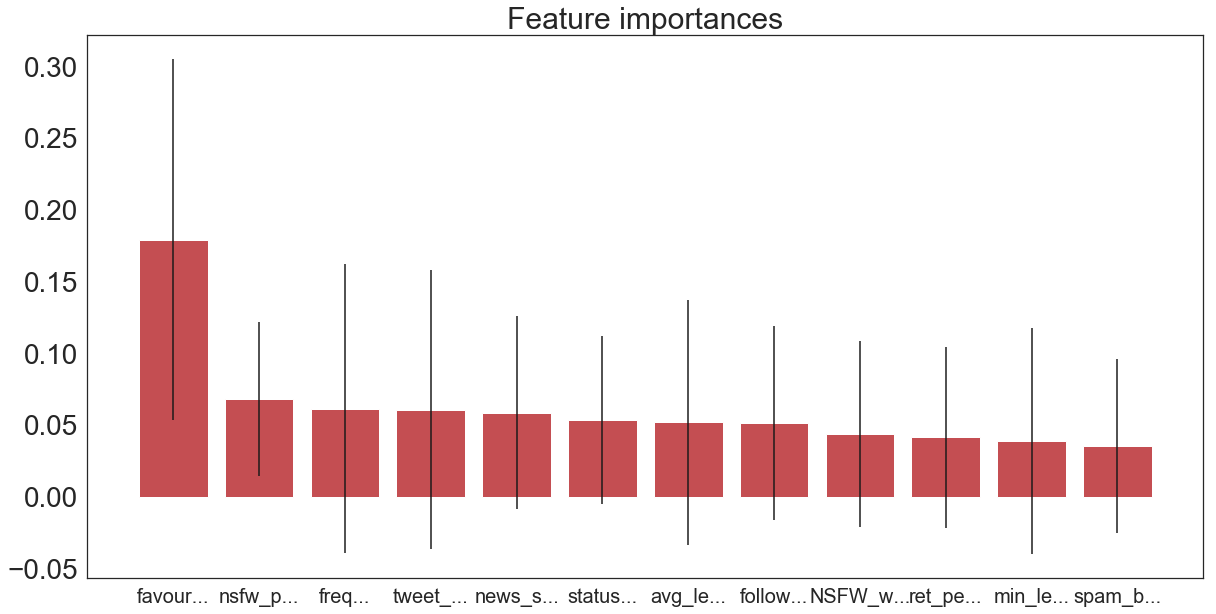

In [26]:
plot_importance(forest, 'top_12_features', X, 6)

## Performance comparison

In [185]:
X_list = [X_user, X_desc, X_intr, X_extr, X_imgs, X]
params = {'n_estimators':[100, 150, 200, 250]}

In [186]:
results = grid_search(X_list, y, params)

user done
descriptive done
extrinsic done
intrinsic done
image done
all done


In [187]:
res = pd.DataFrame()
for elem in results:
    res=res.append(pd.DataFrame(elem), ignore_index=True)

In [188]:
n_estimators = [100, 150, 200, 250]
features = ['user','descriptive','intrinsic','extrinsic','image','all']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


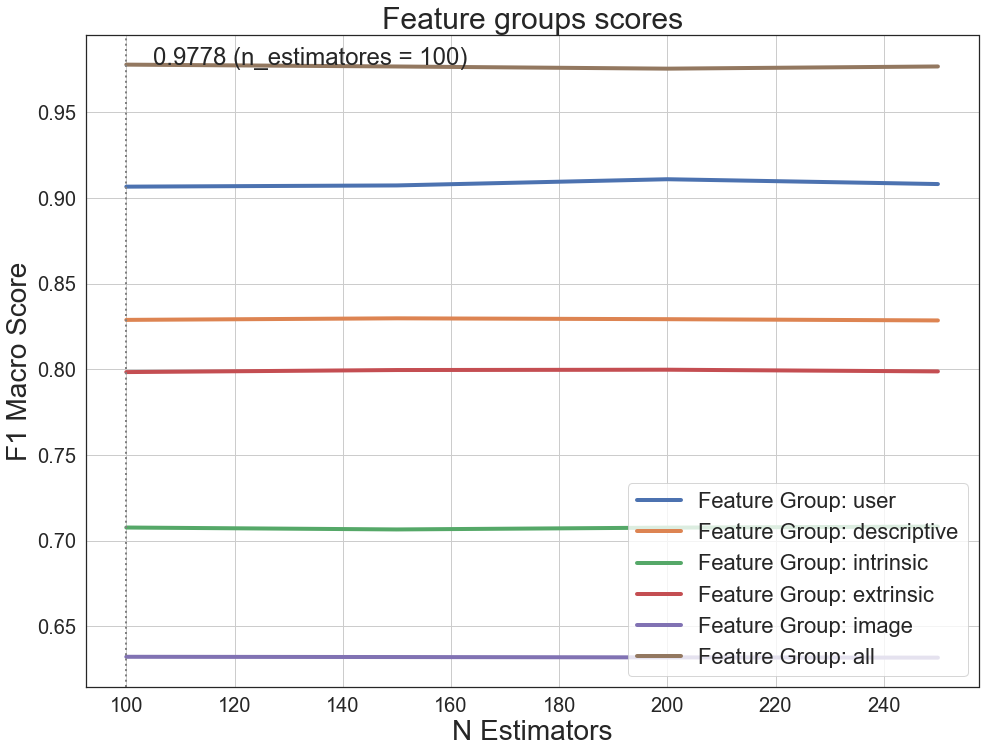

In [189]:
plot_grid_search(res, n_estimators, features, 'N Estimators', 'Feature Group', 'Feature groups scores', 'feature_cluster_f1')

## Plot features Trend

In [190]:
forest = RandomForestClassifier(n_estimators = 100, max_depth=None, criterion='entropy', warm_start=True)

In [191]:
precision, recall, f1, X_axis = features_trend(forest)

1 features tested
2 features tested
3 features tested
4 features tested
5 features tested
6 features tested
7 features tested
8 features tested
9 features tested
10 features tested
11 features tested
12 features tested
13 features tested
14 features tested
15 features tested
16 features tested
17 features tested
18 features tested
19 features tested
20 features tested
21 features tested
22 features tested
23 features tested
24 features tested
25 features tested
26 features tested
27 features tested
28 features tested
29 features tested
30 features tested
31 features tested
32 features tested
33 features tested
34 features tested
35 features tested
36 features tested
37 features tested


/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """


<Figure size 432x288 with 0 Axes>

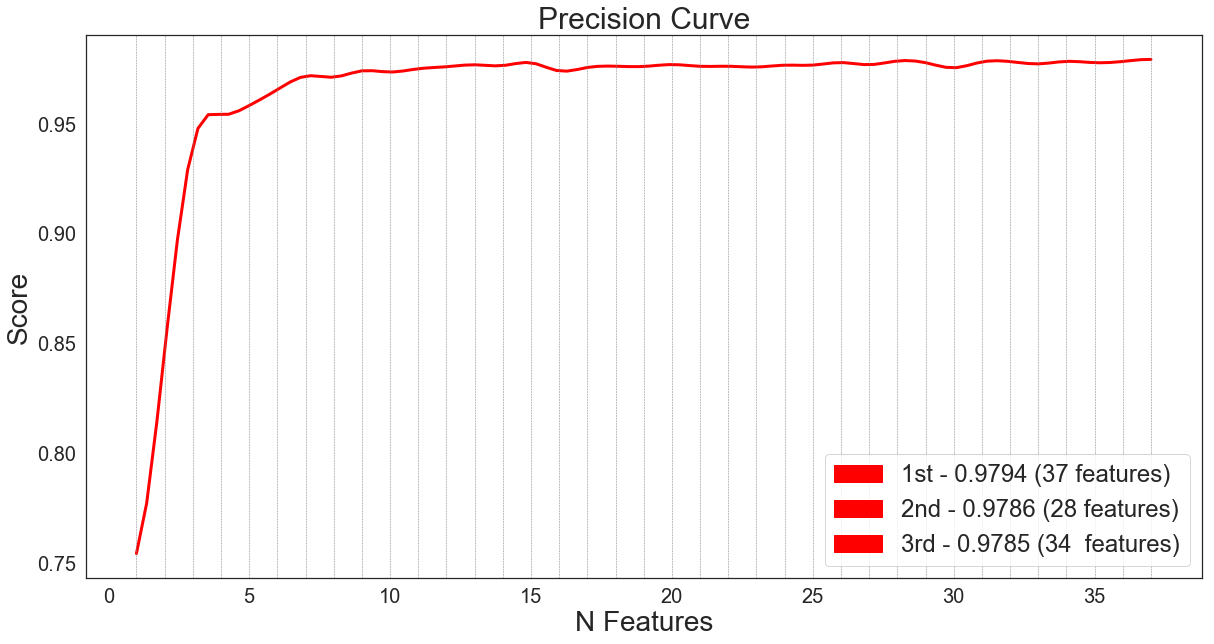

In [192]:
plot_features_trend(precision, X_axis, 'Precision Curve', 'precision_along_features', 'red')

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """


<Figure size 432x288 with 0 Axes>

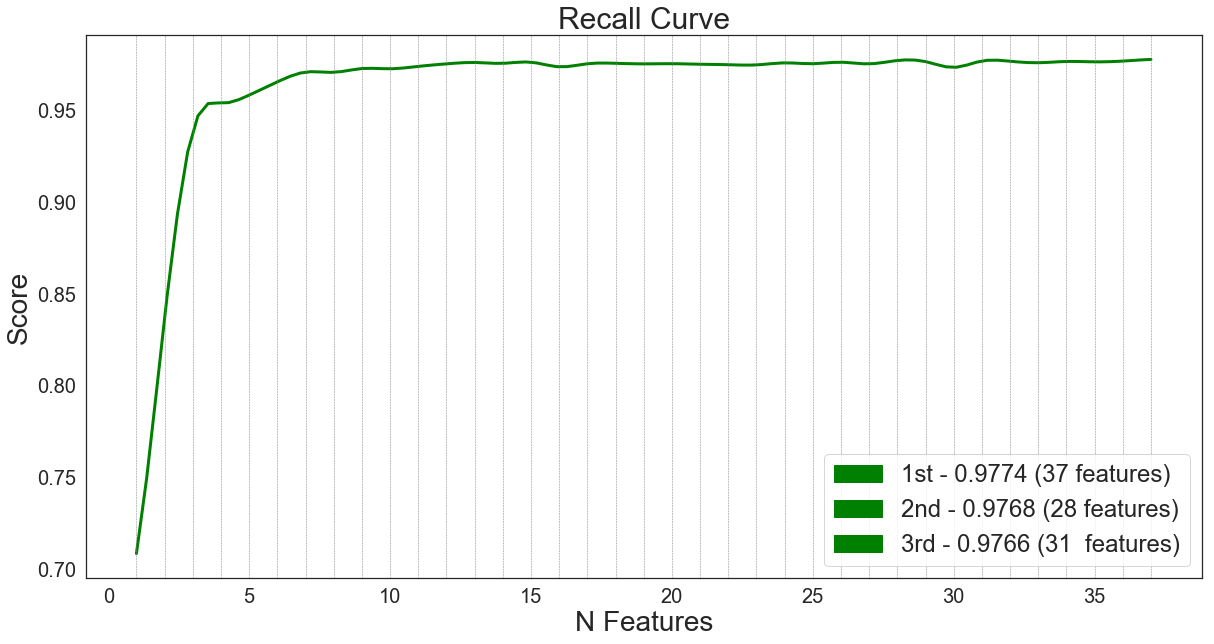

In [193]:
plot_features_trend(recall, X_axis, 'Recall Curve', 'recall_along_features', 'green')

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """


<Figure size 432x288 with 0 Axes>

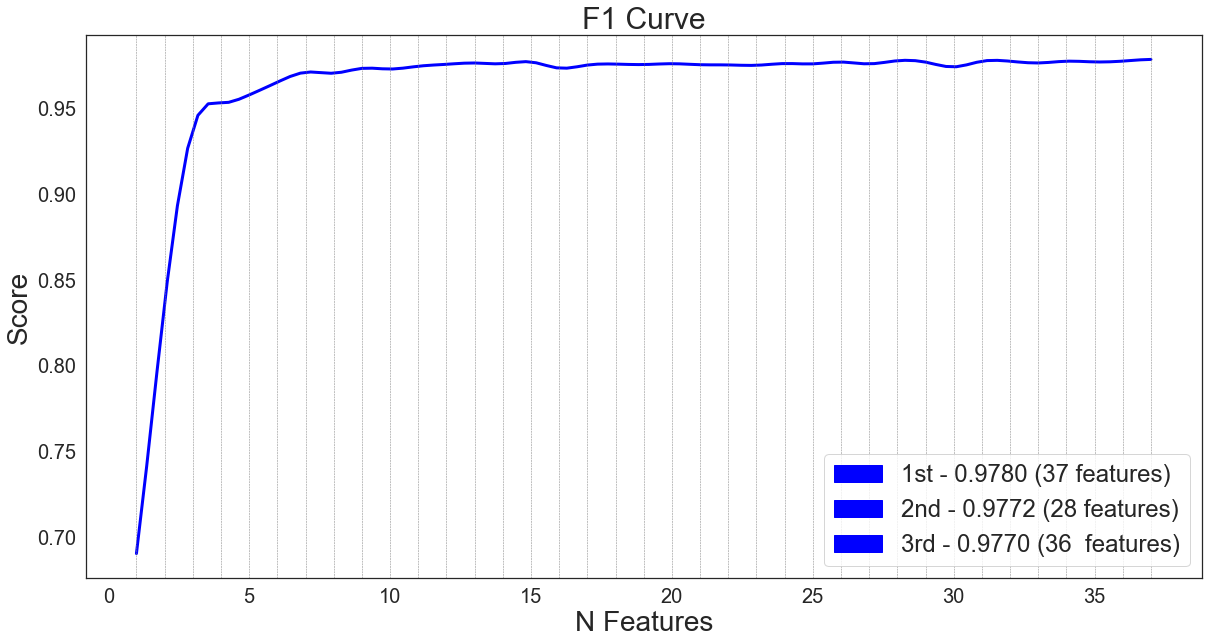

In [194]:
plot_features_trend(f1, X_axis, 'F1 Curve', 'f1_along_features', 'blue')

## Extrinsic Tuning

In [198]:
porn_tweets_df = pd.read_csv('data/porn/tweets.csv', encoding='utf-8-sig', sep='\t')
prop_tweets_df = pd.read_csv('data/propaganda/tweets.csv', encoding='utf-8-sig', sep='\t')
spam_tweets_df = pd.read_csv('data/spam/tweets.csv', encoding='utf-8-sig', sep='\t')
fake_tweets_df = pd.read_csv('data/fake_followers/tweets.csv', encoding='utf-8-sig', sep='\t')

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,4,8,11,18,19,20,23,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Dictionaries Comparison

In [216]:
def plot_importance_dict(df, n):
    
    forest = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', max_depth=None, n_jobs=-1)
    X = df.drop(columns=["user_id", "target"])
    y = df['target']
    forest.fit(X,y)
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    
    feat = []
    others = []
    count = []
    for f,i in zip(range(0,len(importances)),indices):
        if X.columns[i] in ['NSFW_words_score', 'news_spreaders_words_score',
       'spam_bots_words_score', 'fake_followers_words_score']:
            print("%d. %s (%f)" % (f + 1, X.columns[i], importances[indices[f]]))
            feat.append(f)
            count.append(i)
        else:
            others.append(f)

    # Plot the feature importances of the forest
    plt.figure()
    plt.figure(figsize=(20,10))

    plt.title("Feature importances", fontsize=30)
    bars = plt.bar(range(len(importances)), importances[indices],
           color="blue", yerr=std[indices], align="center")
    for f in feat:
        bars[f].set_color('r')
    
    labels = []
    for l in X.columns[indices]:
        if l in feat:
            labels.append(str(l[0:5]) + '...')
        else:
            labels.append('')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=28)
    plt.xticks(range(len(importances)), labels)
    plt.xlim([-1, len(importances)])
    plt.savefig('data/full/features_importances_' + str(n) + '.png')
    plt.show()
    return np.array(sorted(importances)[::-1]), feat, count

In [200]:
def plot_importance_close(df, importances, feat, i, n):
    
    X = df.drop(columns=["user_id", "target"])
    y = df['target']

    # Plot the feature importances of the forest
    plt.figure()
    plt.figure(figsize=(20,10))

    plt.title("Extrinsic features close-up", fontsize=30)
    bars = plt.bar(range(len(feat)), importances[feat],
           color="r", align="center")
    
    labels = []
    for l in X.columns[i]:
        labels.append(str(l[0:12]) + '...')
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xticks(range(len(feat)), labels)
    plt.xlim([-1, len(feat)])
    plt.savefig('data/full/features_importances_' + str(n) + '_closeup.png')
    plt.show()

In [201]:
df_250 = pd.read_csv('data/full/train_250.csv')

In [218]:
df_250 = df_250.rename(columns={'porn_words_score': 'NSFW_words_score', 'prop_words_score': 'news_spreaders_words_score', 'spam_words_score': 'spam_bots_words_score', 'fake_words_score''fake_followers_words_score'})

In [202]:
df_500 = pd.read_csv('data/full/train_500.csv')

In [220]:
df_500 = df_500.rename(columns={'porn_words_score': 'NSFW_words_score', 'prop_words_score': 'news_spreaders_words_score', 'spam_words_score': 'spam_bots_words_score', 'fake_words_score': 'fake_followers_words_score'})

In [203]:
df_750 = pd.read_csv('data/full/train_750.csv')

In [221]:
df_750 = df_750.rename(columns={'porn_words_score': 'NSFW_words_score', 'prop_words_score': 'news_spreaders_words_score', 'spam_words_score': 'spam_bots_words_score', 'fake_words_score': 'fake_followers_words_score'})

In [204]:
df_1000 = full

## 250

Feature ranking:
8. news_spreaders_words_score (0.049543)
10. NSFW_words_score (0.034776)
16. spam_bots_words_score (0.022131)
20. fake_followers_words_score (0.015759)


<Figure size 432x288 with 0 Axes>

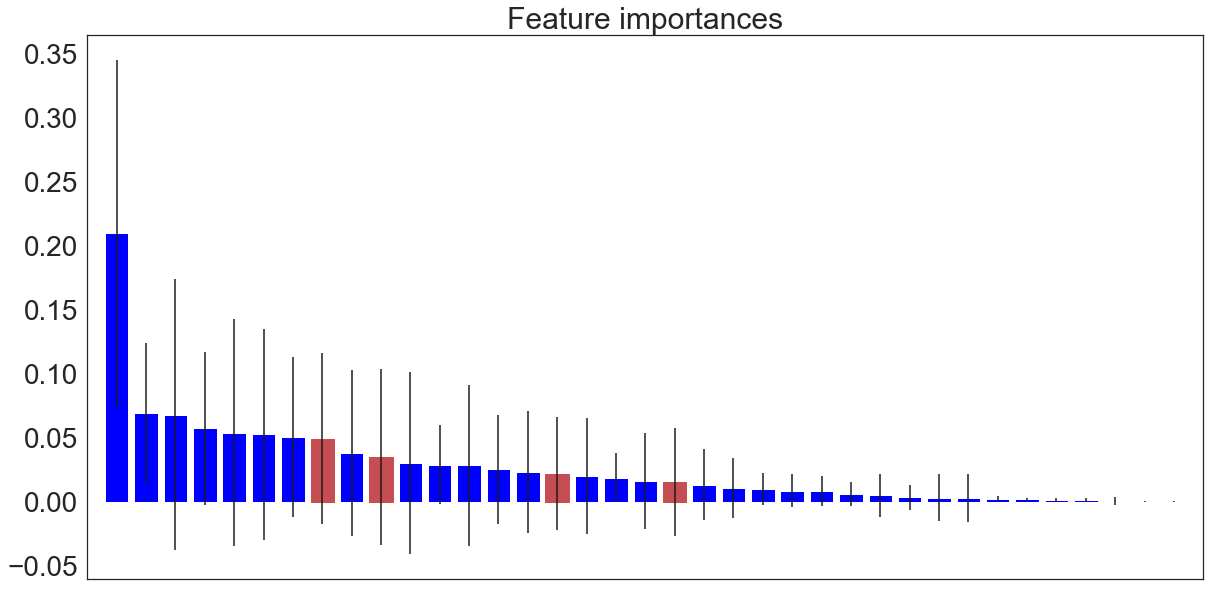

In [222]:
i,f,c = plot_importance_dict(df_250, 250)

<Figure size 432x288 with 0 Axes>

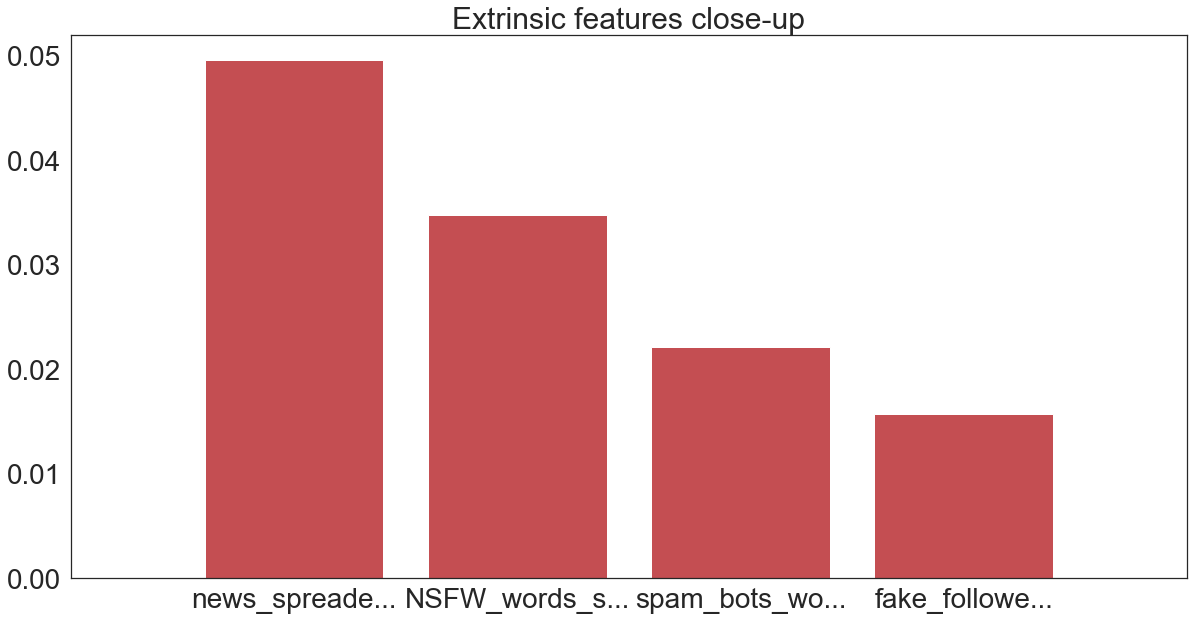

In [223]:
plot_importance_close(df_250,i,f,c,250)

## 500

Feature ranking:
7. news_spreaders_words_score (0.049087)
9. NSFW_words_score (0.040669)
13. spam_bots_words_score (0.027720)
22. fake_followers_words_score (0.009918)


<Figure size 432x288 with 0 Axes>

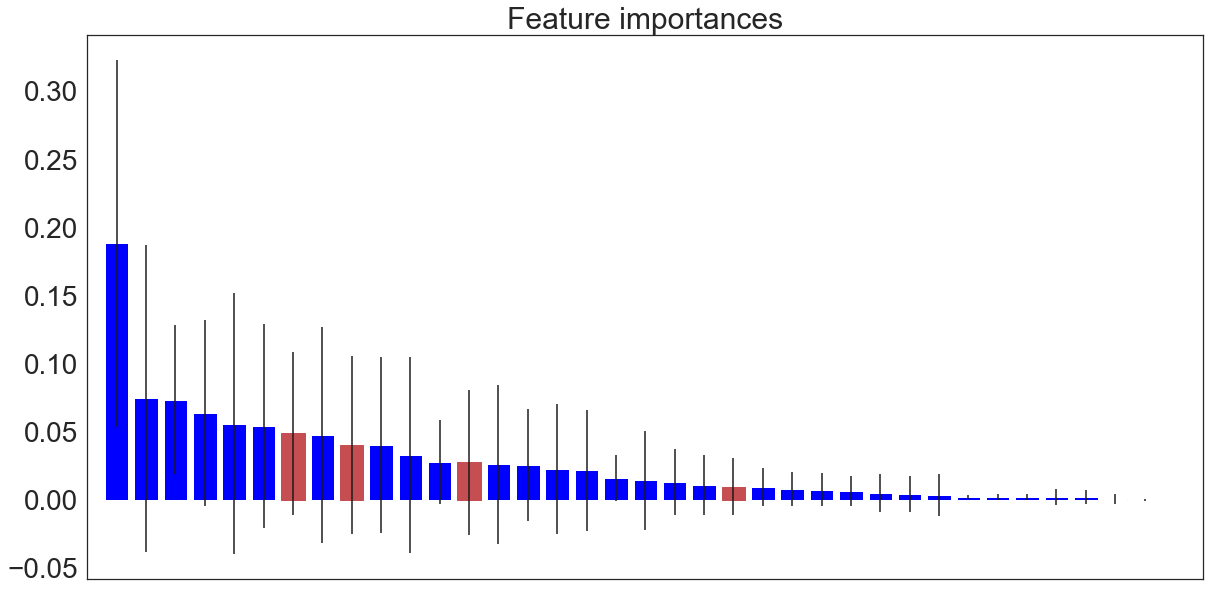

In [224]:
i,f,c = plot_importance_dict(df_500, 500)

<Figure size 432x288 with 0 Axes>

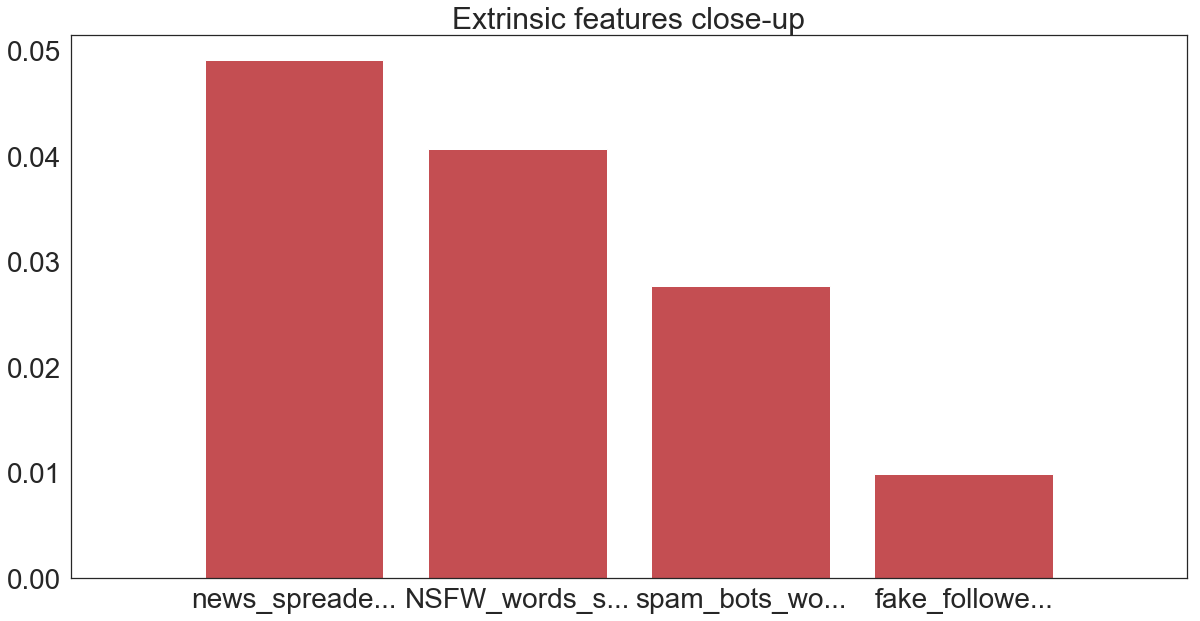

In [225]:
plot_importance_close(df_500,i,f,c,500)

## 750

Feature ranking:
8. news_spreaders_words_score (0.046811)
12. NSFW_words_score (0.034000)
13. spam_bots_words_score (0.030936)
24. fake_followers_words_score (0.009420)


<Figure size 432x288 with 0 Axes>

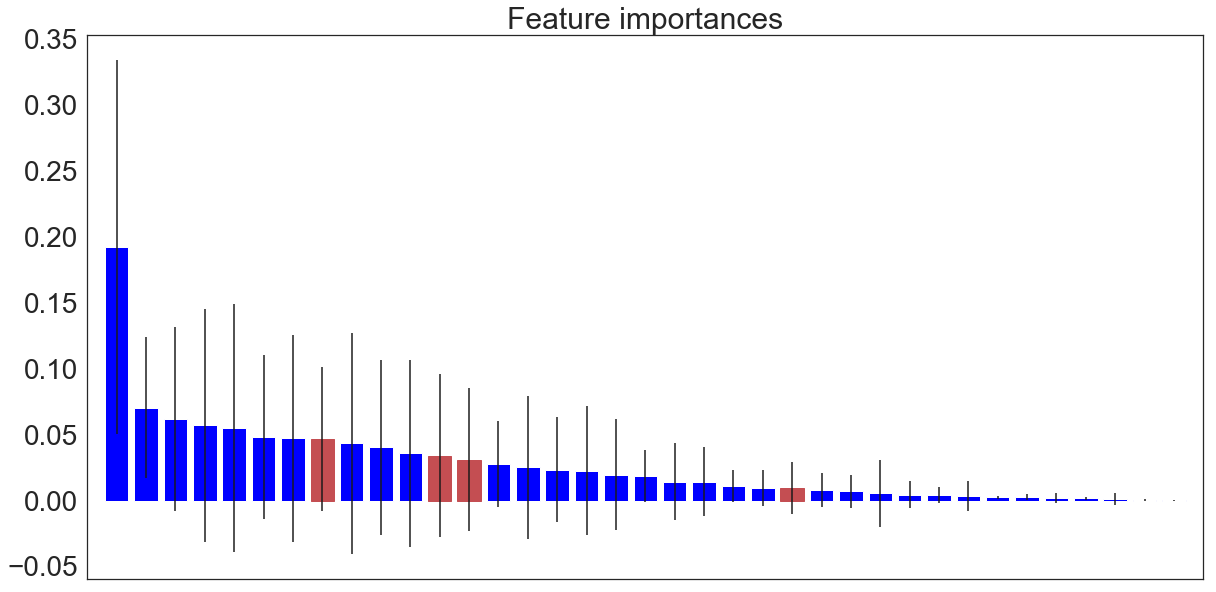

In [226]:
i,f,c = plot_importance_dict(df_750, 750)

<Figure size 432x288 with 0 Axes>

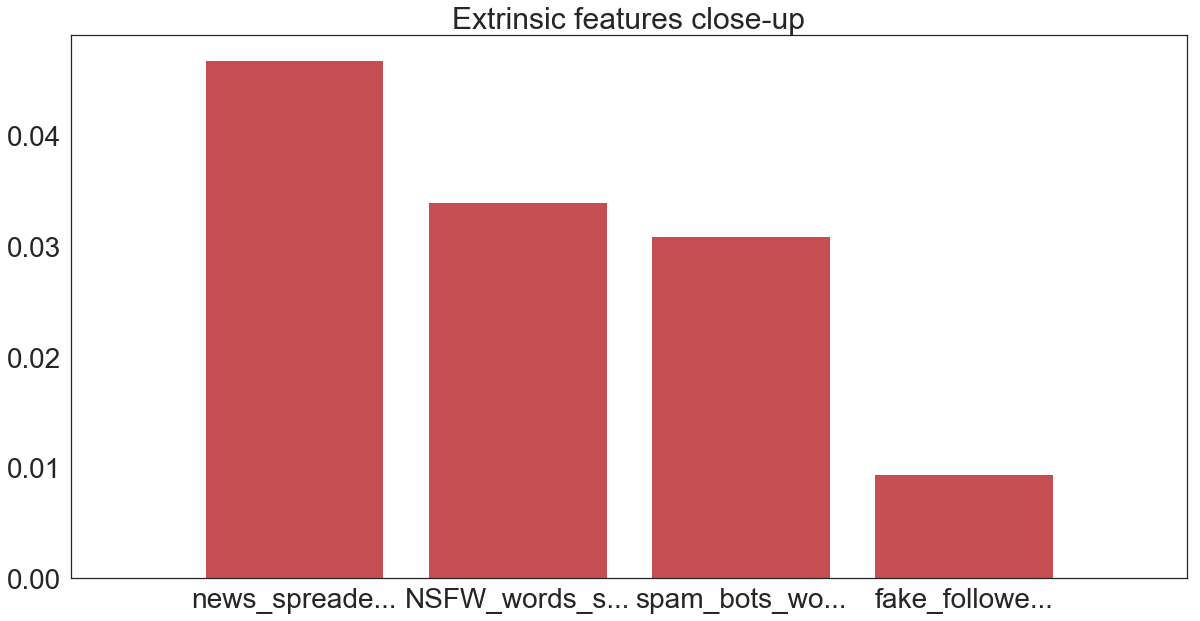

In [227]:
plot_importance_close(df_750,i,f,c,750)

## 1000

Feature ranking:
8. news_spreaders_words_score (0.046796)
14. spam_bots_words_score (0.027325)
16. NSFW_words_score (0.026748)
25. fake_followers_words_score (0.007179)


<Figure size 432x288 with 0 Axes>

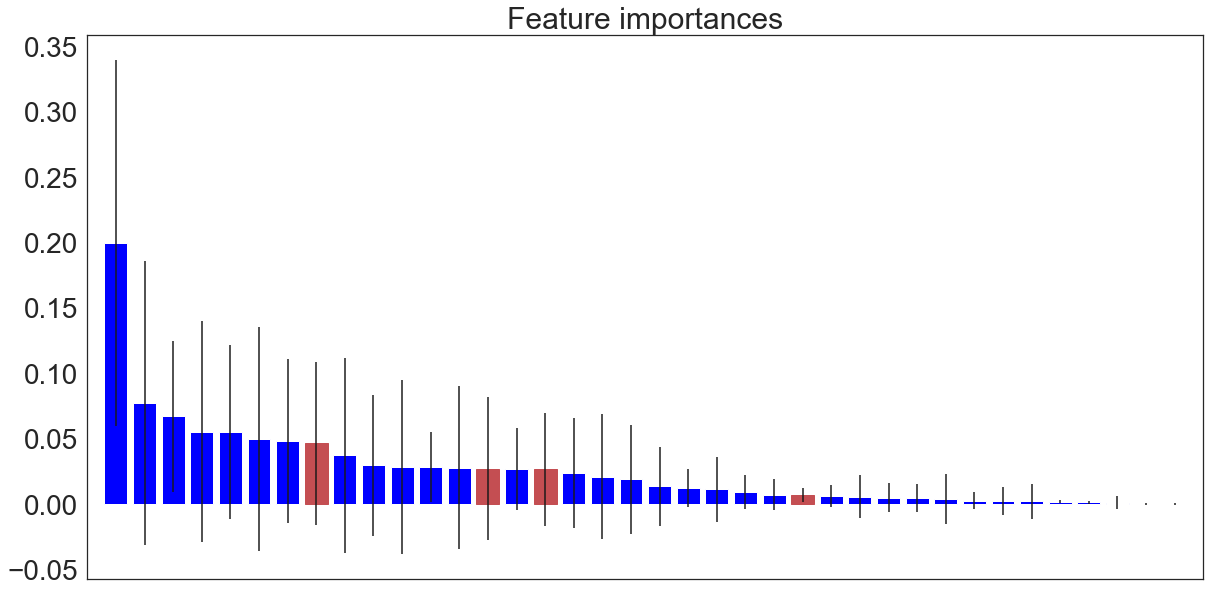

In [228]:
i,f,c = plot_importance_dict(df_1000, 1000)

<Figure size 432x288 with 0 Axes>

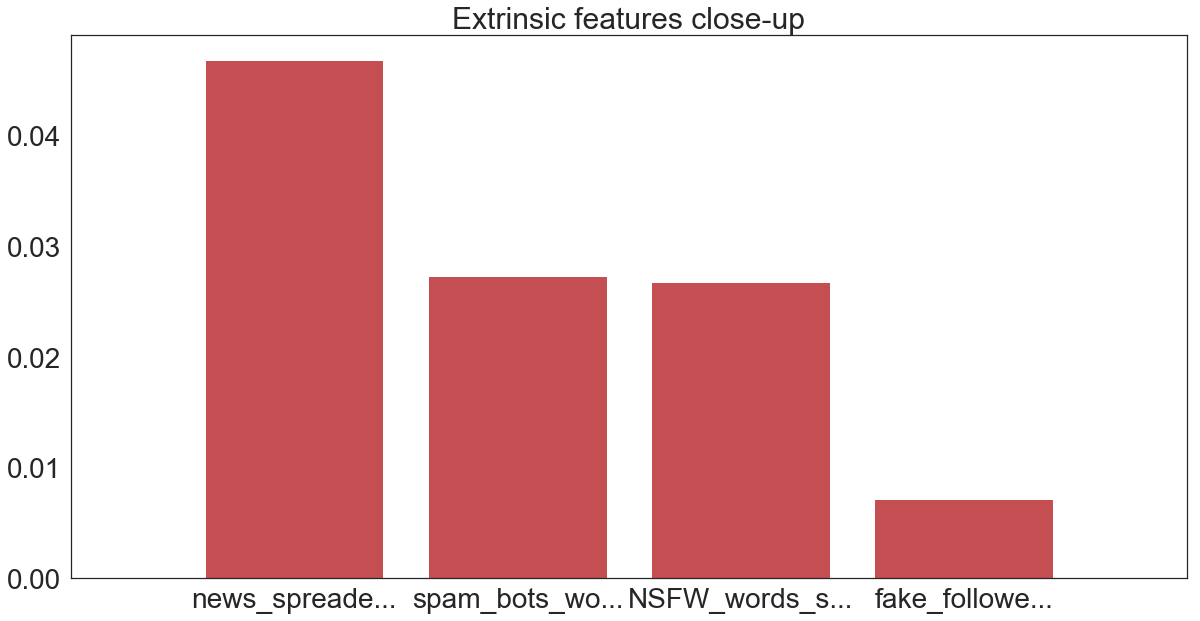

In [229]:
plot_importance_close(df_1000,i,f,c,1000)

## CV Comparison among dictionaries

In [254]:
X_list = [df_1000.drop(columns=['Unnamed: 0','user_id','target']), df_250.drop(columns=['user_id','target']), df_500.drop(columns=['user_id','target']), df_250.drop(columns=['user_id','target'])]
params = {'n_estimators':[50, 100, 150, 200]}
y = df_250['target']

In [238]:
results = grid_search(X_list, y, params)

200 done
250 done
300 done
350 done


In [260]:
res_1000

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score,features
0,2.464704,0.405742,0.026132,0.012017,50,{'n_estimators': 50},0.956119,0.973147,0.973694,0.987616,...,1.0,1.0,1.0,0.999954,0.999856,1.0,0.999925,0.999974,0.000046,100
1,4.354305,0.241298,0.040630,0.007862,100,{'n_estimators': 100},0.953905,0.976454,0.976628,0.988438,...,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,100
2,6.196121,0.535360,0.059413,0.010557,150,{'n_estimators': 150},0.957842,0.976736,0.977761,0.987304,...,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,100
3,9.030603,1.249797,0.082108,0.017280,200,{'n_estimators': 200},0.957124,0.974855,0.976316,0.987634,...,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,100


In [261]:
res=res.append(res_1000, ignore_index=True)

In [279]:
res=res.append(pd.DataFrame(results[1]), ignore_index=True)

In [239]:
res = pd.DataFrame()
for elem in results:
    res=res.append(pd.DataFrame(elem), ignore_index=True)

In [280]:
res = res.sort_values(by=['features','param_n_estimators'])

In [307]:
scores_mean = res['mean_test_score']
scores_mean = np.array(scores_mean).reshape(len(safe_area),len(n_estimators))

In [308]:
scores_mean

array([[0.97613182, 0.97686051, 0.97586658, 0.97699093],
       [0.97376839, 0.97594675, 0.97580833, 0.97631644],
       [0.97530402, 0.97512868, 0.97554454, 0.9752462 ],
       [0.9721564 , 0.97317009, 0.97418304, 0.97519514]])

In [301]:
n_estimators = [50, 100, 150, 200]
safe_area = ['1000','250','500','750']

In [300]:
res[['mean_test_score', 'features', 'param_n_estimators']]
print(res['mean_test_score'][:4].mean())
print(res['mean_test_score'][4:8].mean())
print(res['mean_test_score'][8:12].mean())
print(res['mean_test_score'][12:16].mean())

0.9764624577408223
0.9754599782474329
0.9753058597478843
0.9736761676921315


/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


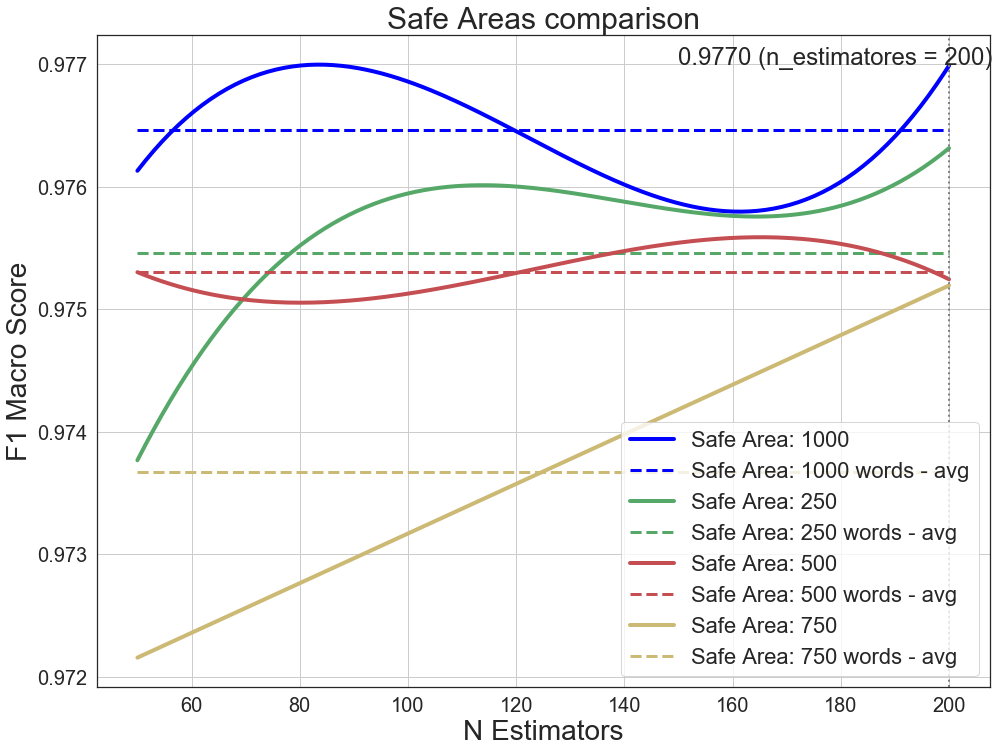

In [314]:
plot_grid_search(res, n_estimators, safe_area, 'N Estimators', 'Safe Area', 'Safe Areas comparison', 'dict_comparison')

## Hyperparameter Tuning

In [28]:
X = full.drop(columns=['user_id','target'])
y = full['target']

## Information Gain

In [319]:
params = {'n_estimators':[200,250,300,350,400,450,500,550,600], 'max_depth':[None,24,28], 'criterion':['entropy']}

In [320]:
grid = grid_eval(X,y, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/

In [329]:
n_estimators = [200,250,300,350,400,450,500,550,600]
max_depth = [24,28,None]

In [327]:
grid.sort_values(by=['mean_test_score'])[['param_max_depth','param_n_estimators','mean_test_score']]

,param_max_depth,param_n_estimators,mean_test_score
0,None,200,0.976460
11,24,300,0.976849
15,24,500,0.977054
18,28,200,0.977179
25,28,550,0.977310
7,None,550,0.977327
17,24,600,0.977330
21,28,350,0.977337
8,None,600,0.977351
24,28,500,0.977397


/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


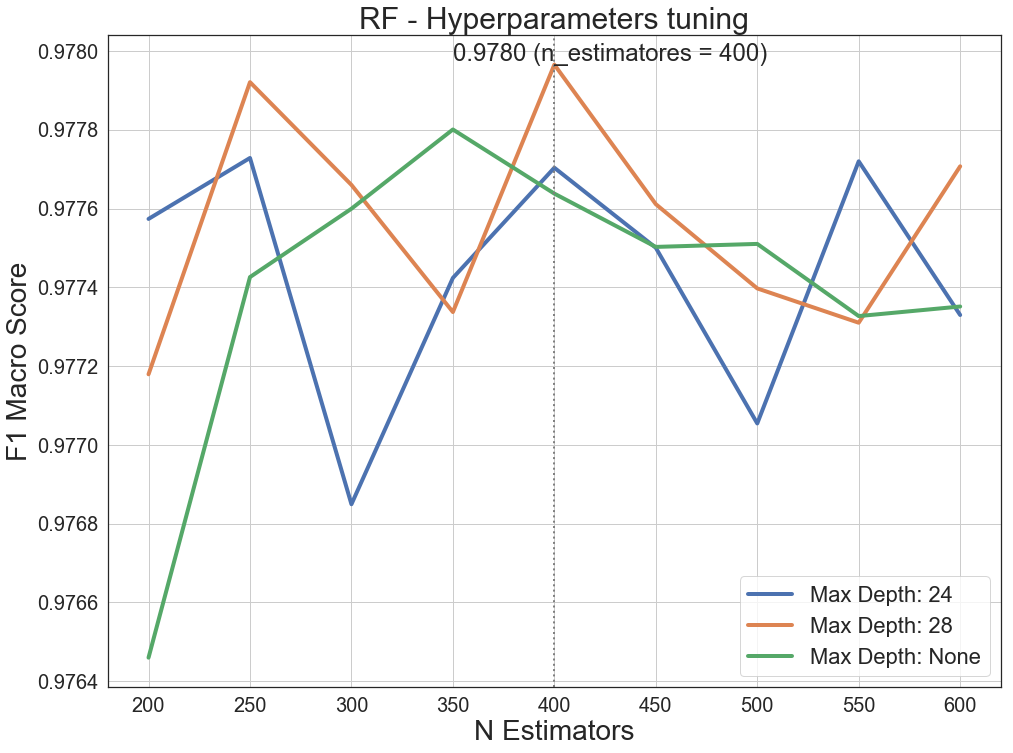

In [330]:
plot_grid_search(grid.sort_values(by=['param_max_depth','param_n_estimators']), n_estimators, max_depth, 'N Estimators', 'Max Depth', 'RF - Hyperparameters tuning', 'multiclass_rf_tuning')

## Gini

In [4]:
X = full.drop(columns=['user_id','target'])
y = full['target']

In [29]:
params = {'n_estimators':[200,250,300,350,400,450,500,550,600], 'max_depth':[None,24,28], 'criterion':['gini']}

In [34]:
grid = grid_eval(X,y, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/

In [35]:
n_estimators = [200,250,300,350,400,450,500,550,600]
max_depth = [24,28,None]

In [36]:
grid.sort_values(by=['mean_test_score'])[['param_max_depth','param_n_estimators','mean_test_score']]

,param_max_depth,param_n_estimators,mean_test_score
19,28,250,0.975310
25,28,550,0.975690
10,24,250,0.975783
14,24,450,0.975914
0,None,200,0.975972
11,24,300,0.976050
7,None,550,0.976114
9,24,200,0.976211
3,None,350,0.976224
6,None,500,0.976311


/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


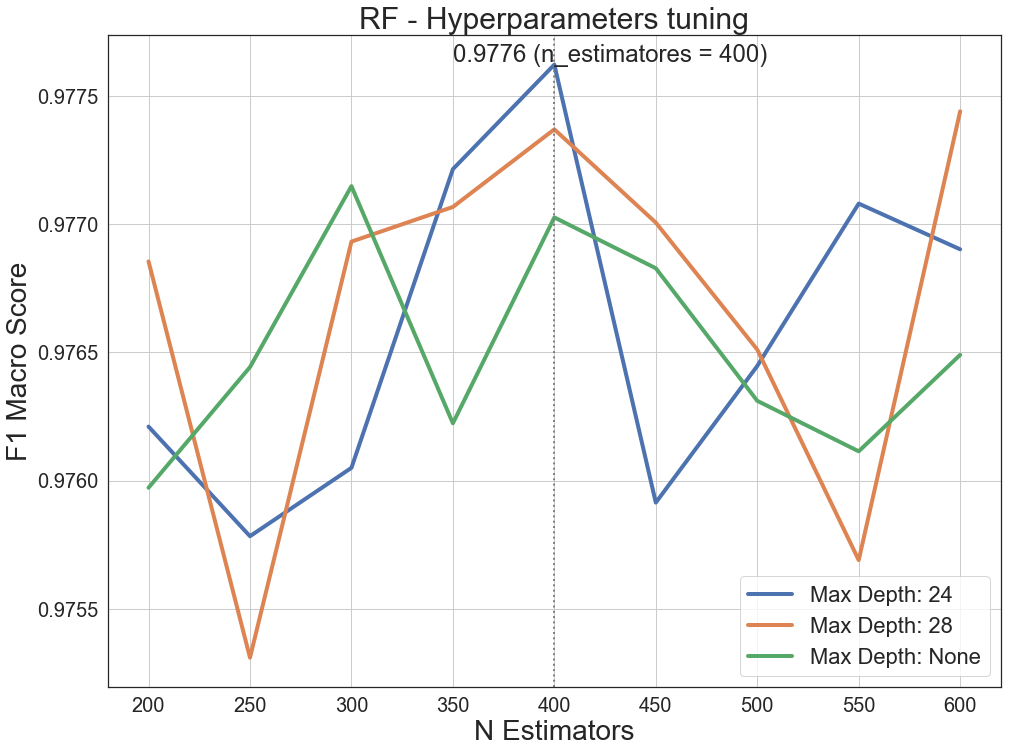

In [37]:
plot_grid_search(grid.sort_values(by=['param_max_depth','param_n_estimators']), n_estimators, max_depth, 'N Estimators', 'Max Depth', 'RF - Hyperparameters tuning', 'multiclass_rf_tuning_gini')

In [2]:
model = RandomForestClassifier(n_estimators = 400, max_depth = 28, criterion = 'entropy')

In [5]:
X = X.reindex(sorted(X.columns), axis=1)

In [42]:
X.head()

,NSFW_words_score,age,avg_fav,avg_hash,avg_len,avg_ret,default_profile,description_len,fake_followers_words_score,favourites_count,...,profile_use_background_image,quote_perc,ret_perc,screen_name_len,spam_bots_words_score,statuses_count,tweet_intradistance,url,url_entropy,url_perc
0,0.003998,11,542.600000,0.140000,135.92,3627.200000,0.0,156,0.004165,96230,...,1.0,0.180000,0.700000,9,0.002663,43347,14.960393,1,2.780639,0.270000
1,0.001652,11,0.000000,0.270000,130.46,929.960000,0.0,159,0.000567,57175,...,1.0,0.170000,1.000000,8,0.002155,193497,15.500559,1,3.240224,0.210000
2,0.000155,11,8.990000,0.010000,99.03,5.980000,0.0,0,0.000000,167,...,0.0,0.000000,0.010000,8,0.000000,54563,13.344548,1,0.000000,1.000000
3,0.013394,11,0.336735,0.469388,114.50,4.693878,0.0,40,0.005282,384,...,1.0,0.020408,0.530612,12,0.010144,511,12.959084,1,4.592029,0.602041
4,0.003287,11,0.250000,0.210000,125.66,1421.170000,0.0,112,0.001516,99630,...,1.0,0.130000,0.760000,15,0.001733,118660,14.280469,0,3.283157,0.330000


In [41]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [334]:
import time

In [335]:
start = time.time()
model.predict_proba(np.array(X.iloc[0]).reshape(1, -1))
end = time.time()
print("Prediction time: " + str(end - start))

Prediction time: 0.05762505531311035


In [43]:
pickle.dump(model, open("../scripts/rf.model", "wb"))

In [126]:
df_1000 = df_1000.drop(columns=['min_fav'])

In [128]:
df_1000.to_csv('data/full/rf_preproc_train.csv')

## Plot Decision Surface

In [48]:
from sklearn.tree import export_graphviz
import matplotlib.image as mpimg
from subprocess import call

def visualize_classifier(model, X, n, d):
    
    tree = model.estimators_[n]
    # Export as dot file
    export_graphviz(tree, out_file='tree.dot',
                max_depth=d,
                feature_names=X.columns,
                filled=True,
                rounded=True)

    # Convert to png using system command (requires Graphviz)
    
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'])
    img=mpimg.imread('tree.png')
    
    plt.figure(figsize=(20,10))
    plt.axis('off')
    
    plt.imshow(img)

In [6]:
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
classes = df['class']

NameError: name 'df' is not defined

In [340]:
X = full.drop(columns=["Unnamed: 0", "user_id", "target"])
y = full['target']

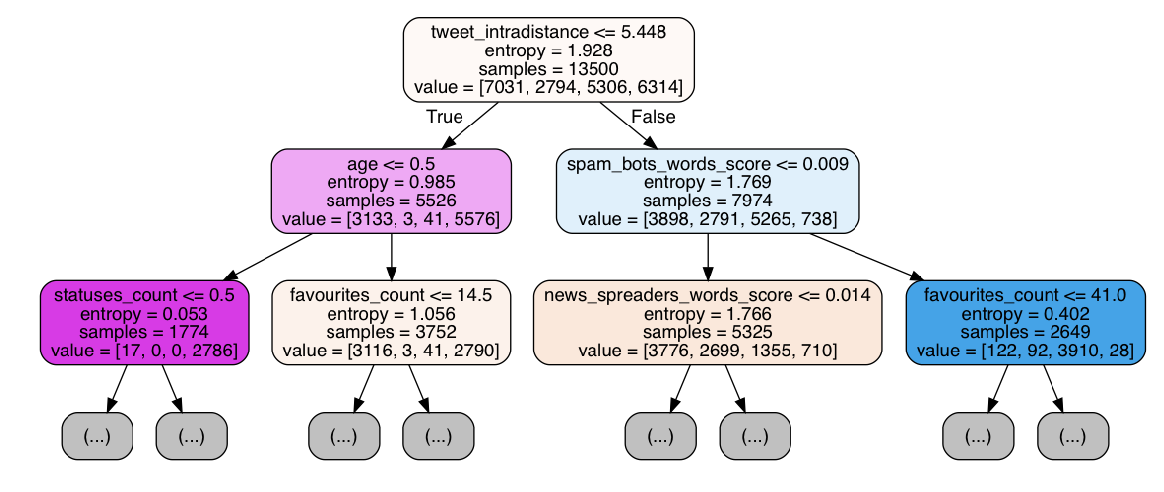

In [49]:
visualize_classifier(model, X, 3, 2)

In [345]:
X.columns

Index(['NSFW_words_score', 'news_spreaders_words_score',
       'spam_bots_words_score', 'fake_followers_words_score', 'avg_fav',
       'avg_hash', 'avg_len', 'avg_ret', 'default_profile', 'favourites_count',
       'followers_count', 'freq', 'friends_count', 'listed_count', 'max_fav',
       'max_hash', 'max_len', 'max_ret', 'media_perc', 'min_hash', 'min_len',
       'min_ret', 'nsfw_avg', 'nsfw_profile', 'profile_use_background_image',
       'quote_perc', 'ret_perc', 'statuses_count', 'tweet_intradistance',
       'url', 'url_perc', 'description_len', 'name_len', 'screen_name_len',
       'age', 'url_entropy', 'min_fav'],
      dtype='object')

In [90]:
X = X.rename(columns={'porn_words_score': 'NSFW_words_score', 'prop_words_score': 'news_spreaders_words_score',
                     'spam_words_score': 'spam_bots_words_score', 'fake_words_score': 'fake_followers_words_score'})


In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [12]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target     0    1     2     3
Actual Target                          
0                 1747    3    14     1
1                    8  705    19     1
2                    8    6  1301     0
3                   11    1     2  1535
